In [ ]:
import cv2
import imghdr
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
source_dir = "/content/gdrive/MyDrive/Sea_research/Dataset"

In [ ]:
source_dir

'/content/gdrive/MyDrive/Sea_research/Dataset'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(source_dir)

Found 285 files belonging to 3 classes.


In [ ]:
class_names = sorted(os.listdir(source_dir))
class_names

['img_cat1', 'img_cat2', 'img_cat3']

In [ ]:
class_label_dict = {index : element for index,element in enumerate(class_names)}
class_label_dict

{0: 'img_cat1', 1: 'img_cat2', 2: 'img_cat3'}

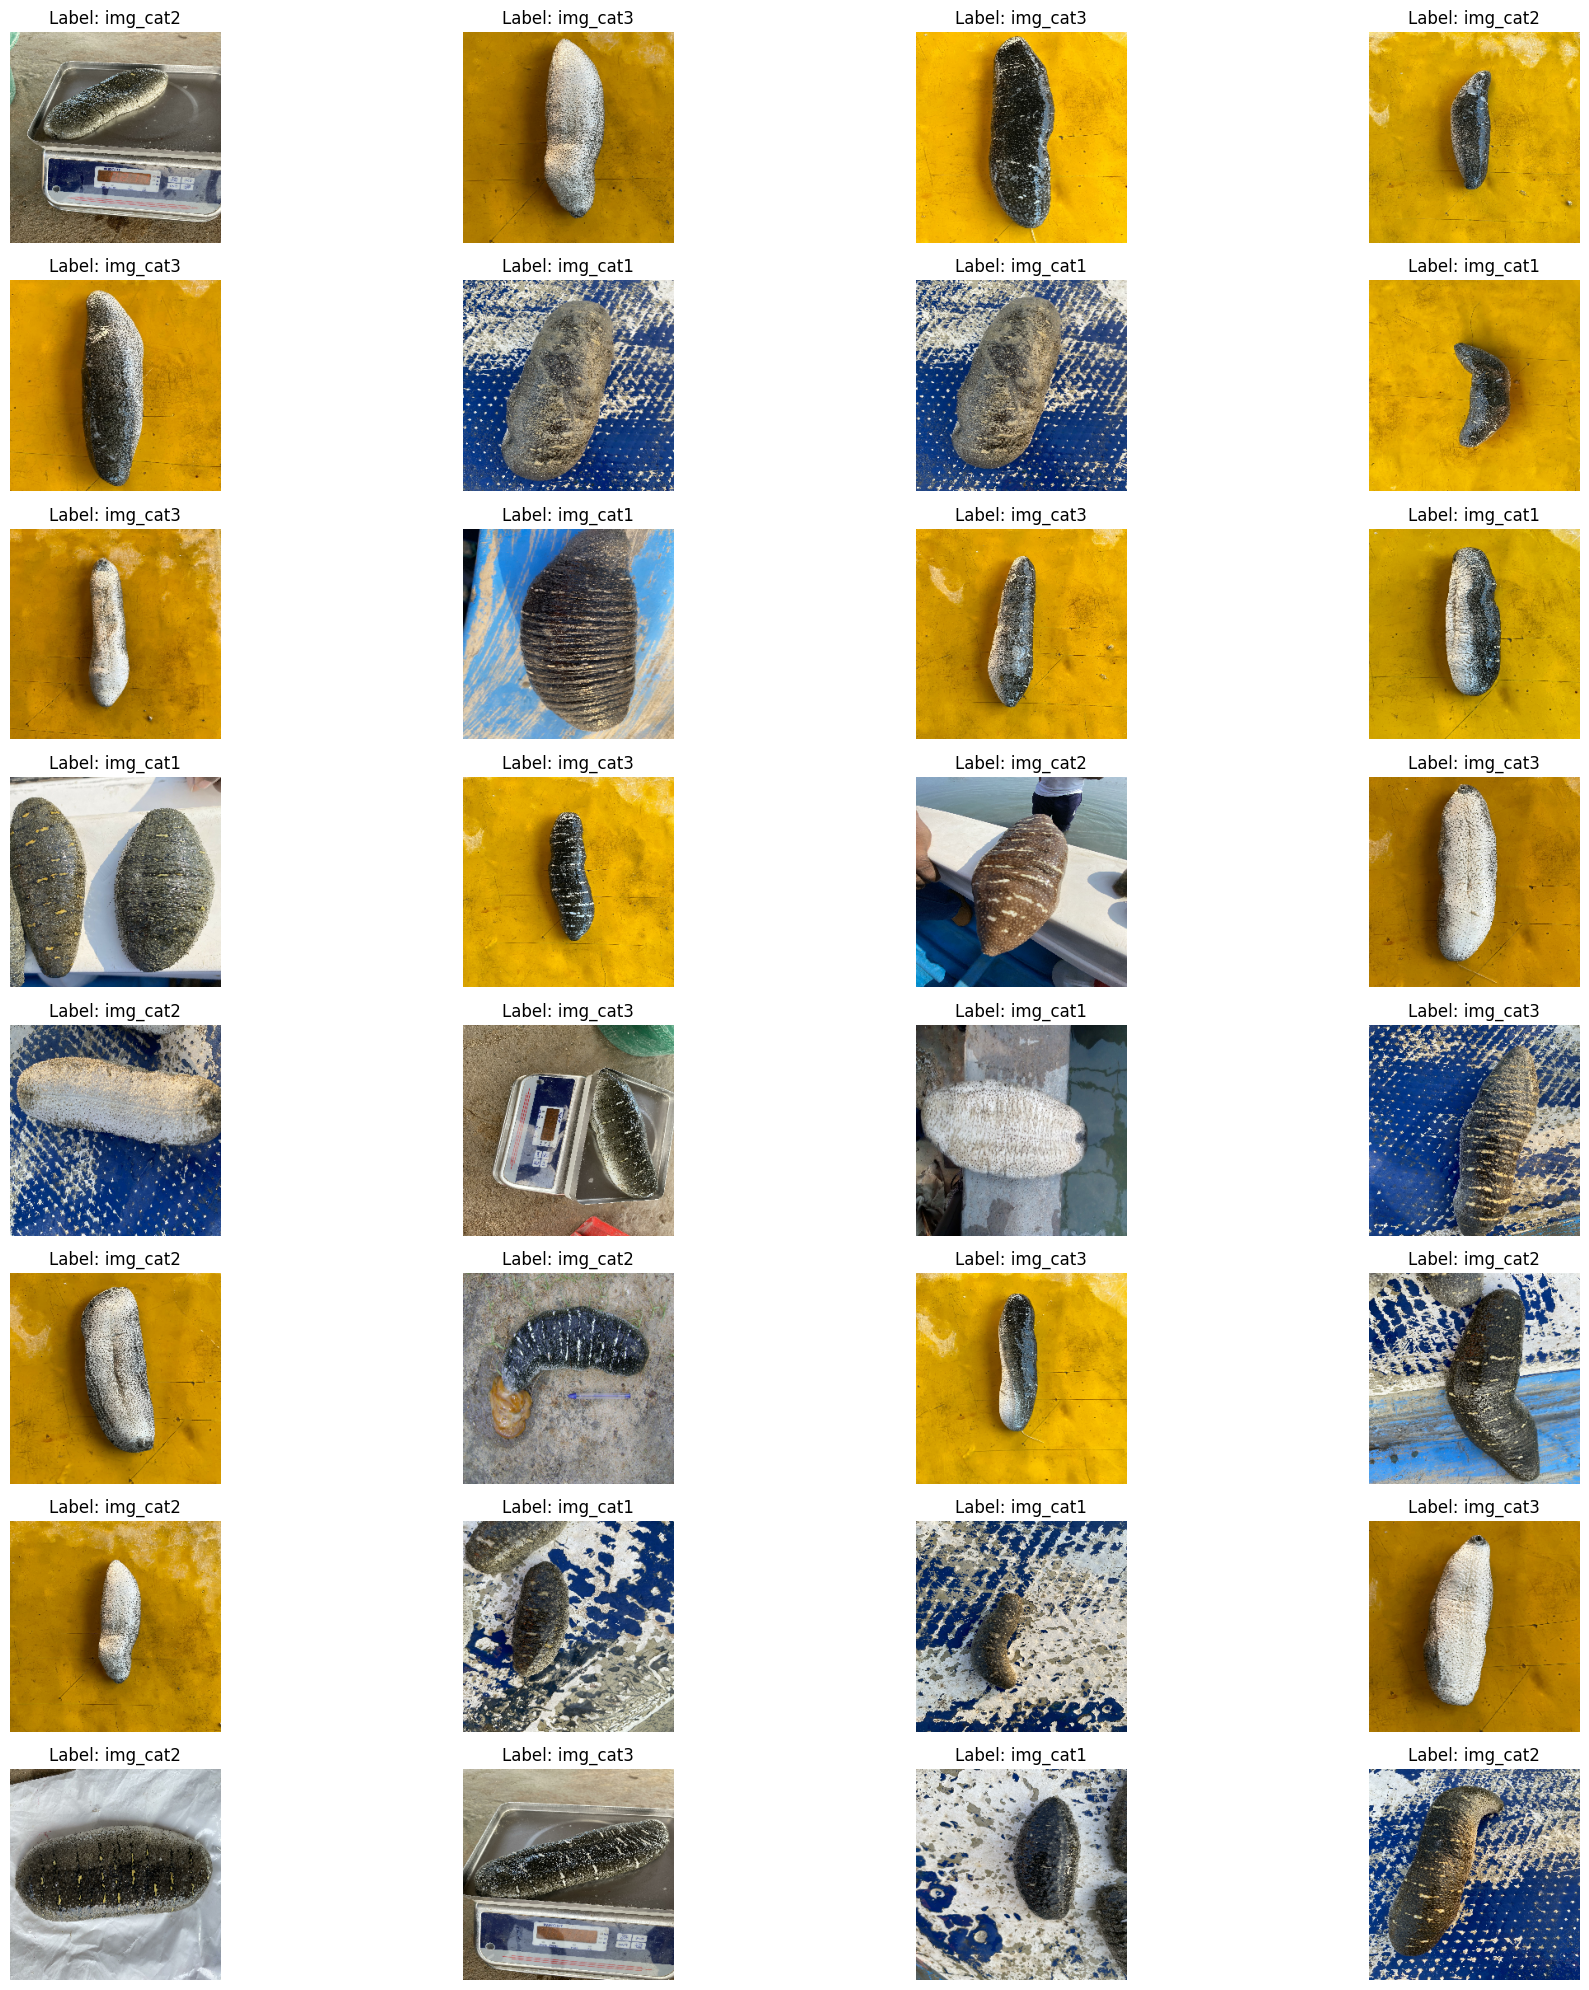

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
X, y = batch

num_columns = min(len(X), 4)

fig, ax = plt.subplots(nrows = len(X)//num_columns, ncols=4, figsize=(20,20))

for i in range(len(X)):
  row_idx = i // num_columns
  col_idx = i % num_columns

  image = X[i]
  true_label = y[i]
  
  # Plot the image and display the true and predicted labels
  ax[row_idx, col_idx].imshow(image.astype(int))
  ax[row_idx, col_idx].set_title(f'Label: {class_label_dict[true_label]}')
  ax[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train = data.take(train_size)

class_counts = {}

for _, labels in train:

    for label in labels:

        label_str = str(label.numpy())
        label_real = label.numpy()

        if label_str in class_counts:
            class_counts[label_str] += 1
        else:
            class_counts[label_str] = 1

for label, count in class_counts.items():
    print(f"Class {label}: {count}")

Class 2: 69
Class 0: 51
Class 1: 72


In [ ]:
min_value = min(class_counts.values())

class_weights = {0: min_value/class_counts['0'], 1: min_value/class_counts['1'], 2: min_value/class_counts['2']  }
class_weights

{0: 1.0, 1: 0.7083333333333334, 2: 0.7391304347826086}

In [ ]:
num_classes = 4

data = data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [ ]:
train_size, val_size, test_size

(6, 1, 0)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
conv_base.trainable = False

In [ ]:
model = Sequential([
    
    conv_base,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(num_classes, activation = 'softmax')
])


In [ ]:
model.compile('adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
______________________________________

In [ ]:
logdir = "/content/gdrive/MyDrive/Sea_research/Log"

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=18, validation_data=val, callbacks=[tensorboard_callback], class_weight=class_weights)

Epoch 1/18
6/6 [==============================] - 131s 21s/step - loss: 0.9843 - accuracy: 0.3750 - val_loss: 1.1821 - val_accuracy: 0.3750
Epoch 2/18
6/6 [==============================] - 130s 21s/step - loss: 0.9159 - accuracy: 0.4219 - val_loss: 1.0789 - val_accuracy: 0.4375
Epoch 3/18
6/6 [==============================] - 152s 25s/step - loss: 0.8725 - accuracy: 0.4896 - val_loss: 0.9869 - val_accuracy: 0.4688
Epoch 4/18
6/6 [==============================] - 148s 24s/step - loss: 0.8319 - accuracy: 0.4792 - val_loss: 1.1424 - val_accuracy: 0.4375
Epoch 5/18
6/6 [==============================] - 128s 21s/step - loss: 0.8068 - accuracy: 0.4896 - val_loss: 0.8936 - val_accuracy: 0.5312
Epoch 6/18
6/6 [==============================] - 129s 21s/step - loss: 0.7828 - accuracy: 0.5260 - val_loss: 1.0184 - val_accuracy: 0.5000
Epoch 7/18
6/6 [==============================] - 151s 25s/step - loss: 0.7758 - accuracy: 0.5260 - val_loss: 0.7689 - val_accuracy: 0.6562
Epoch 8/18
6/6 [====

In [ ]:

import datetime
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
model_name = 'cat_classifier_model1_{}.h5'.format(formatted_datetime)
model_path = "/content/gdrive/MyDrive/Sea_research/Models"

In [ ]:
model.save(model_path)

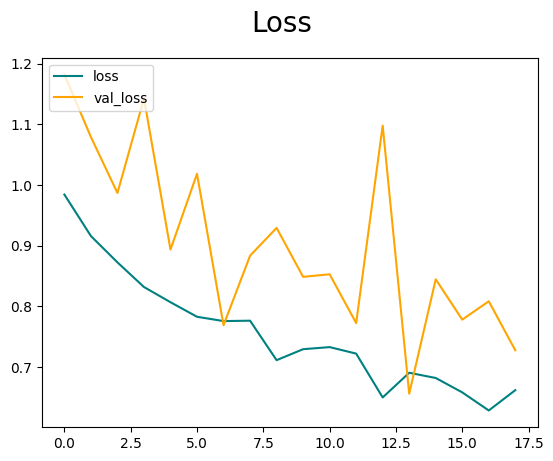

In [ ]:
# Loss and the validation loss in the training phase
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

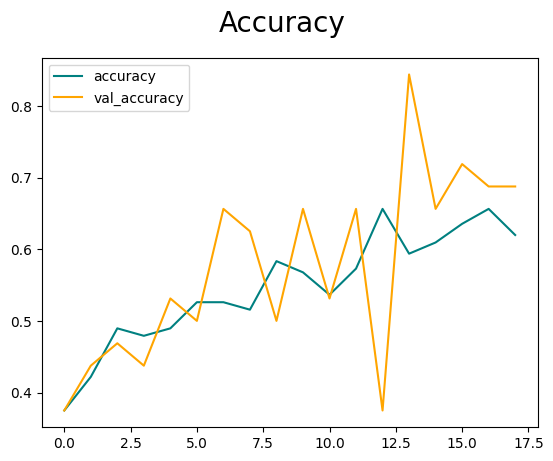

In [ ]:
#Training Accuracy and validation accuracy in the training phase

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_true = []
y_pred = []

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X) # predicting the test data set
  

    y_true.append(y)
    y_pred.append(yhat)

In [ ]:
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
from tensorflow.keras.preprocessing import image

def classify_image(model, image_path):

  class_label_dict = {0: 'img_cat1', 1: 'img_cat2', 2: 'img_cat3' }

  image_path = image_path
  img = image.load_img(image_path, target_size=(256, 256, 3))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

 
  
  predictions = model.predict(img_array);

  predicted_probabilities = predictions[0]
  predicted_class = np.argmax(predicted_probabilities)

  plt.imshow(img)
  plt.title('Predition : {} | probability : {}'.format(class_label_dict[predicted_class], max(predicted_probabilities)))

1/1 [==============================] - 1s 603ms/step


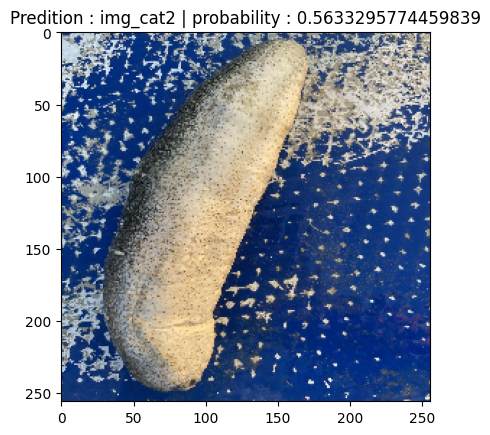

In [ ]:
img_path = '/content/gdrive/MyDrive/Sea_research/IMG_1608.jpg'
classify_image(loaded_model, img_path)


 